In [1]:
%cd /om/user/xboix/src/adversarial/Robustness

/om/user/xboix/src/adversarial/Robustness


In [2]:
experiment_name = "cifar"
results_dir = '/vast/robustness/' + experiment_name + '/'

In [3]:
import seaborn as sns
sns.set_theme(style="ticks")
sns.set_context("poster")

import matplotlib.pyplot as plt
import pandas as pd
import pickle 
import os 

import numpy as np
import pandas
    
import runs.config_experiments_cifar as run
experiment_list = run.config_experiments(results_dir, create_json=False)

951 config files created


In [4]:
name_attacks = ["linf_pgd","l2_pgd", "linf_fgsm", "l2_fgm"]

In [20]:
list_entries = []

for attack in name_attacks:

    file_name = results_dir + experiment_list[0]['model_name'] + '/results/acc_' + 'val' + '_' + attack + '.pkl'
    if not os.path.isfile(file_name):
        print("Missing!! " + file_name)
        continue
    with open(file_name, 'rb') as f:
        tmp = pickle.load(f)
                            
                            
    for cv_epsilon in list(tmp.keys()):
        # Hash table of parameters
        parameters = {"epsilon": {}, "backbone": {}, "initial_learning_rate": {}, 
                      "robust_training": {}, "type_robust": {}, "epsilon_pgd_training":{}}

        to_exclude = []
        experiment_list_tmp = [element for i, element in enumerate(experiment_list) if i not in to_exclude]
        for exp in experiment_list_tmp:
            if not exp['data_set'] == 67: 
                continue
            for kk in parameters.keys():
                if exp[kk] in parameters[kk]:
                    parameters[kk][exp[kk]].append(int(exp["model_name"]))
                else:
                    parameters[kk][exp[kk]] = [int(exp["model_name"])]


        # For all methods, do cross-val and create an entry of the results
        backbones = ['CNN', 'CNN+pgd']
        type_robust_trainings = ['linf','l1']

        for backbone in backbones:
            for robust_training in [True, False]:
                for type_robust in type_robust_trainings:

                    if (backbone == 'Madry' and robust_training == True) or \
                        (backbone == 'CNN+clipping' and robust_training == False):
                        continue

                    if robust_training==False:
                        ids = list(set(parameters["backbone"][backbone]) & 
                                   set(parameters["robust_training"][False]))
                    else:
                        ids = list(set(parameters["backbone"][backbone]) & 
                               set(parameters["robust_training"][True])&
                              set(parameters["type_robust"][type_robust]))
             


                    if backbone == 'MLP+pgd' and robust_training == True:
                        continue

                    if ids == []:
                        continue
                    #print(ids)


                    # Cross-validation among learning rates and epsilons:
                    best_acc = -1
                    best_id = ids[0]
                    for id in ids:
                        file_name = results_dir + experiment_list[id]['model_name'] + '/results/acc_' + 'val' + '_' + attack + '.pkl'
                        if not os.path.isfile(file_name):
                            print("Missing!! " + file_name)
                            continue
                        with open(file_name, 'rb') as f:
                            tmp = pickle.load(f)

                        acc = tmp[cv_epsilon]
                        if acc>best_acc:
                            best_id = id
                            best_acc = acc

                    if (robust_training == False) & (backbone=='CNN'):  
                        name_legend = 'vanilla'
                    elif backbone=='CNN+pgd':
                        name_legend = 'pgd'
                    else:
                        name_legend = type_robust

                    entry = {"learning_rate": experiment_list[best_id]['initial_learning_rate'],
                            "backbone": experiment_list[best_id]['backbone'],
                            "robust_training": name_legend,
                            "epsilon": experiment_list[best_id]['epsilon'],
                            "epsilon_pgd_training": experiment_list[best_id]['epsilon_pgd_training']}

                    dataset = "test"
                    entry["attack"] = attack
                    entry["experiment_id"] = best_id

                    with open(results_dir + experiment_list[best_id]['model_name'] + '/results/acc_' + dataset + '_' + 
                        attack + '.pkl', 'rb') as f:
                        tmp = pickle.load(f)

                    entry["test_epsilon"] = cv_epsilon
                    entry["accuracy"] =  100*tmp[cv_epsilon]
                    list_entries.append(entry.copy())

df_results = pd.DataFrame.from_dict(list_entries) 


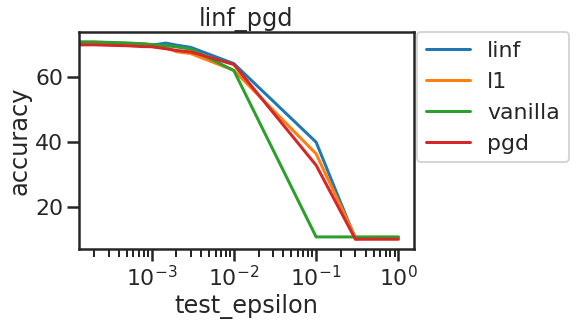

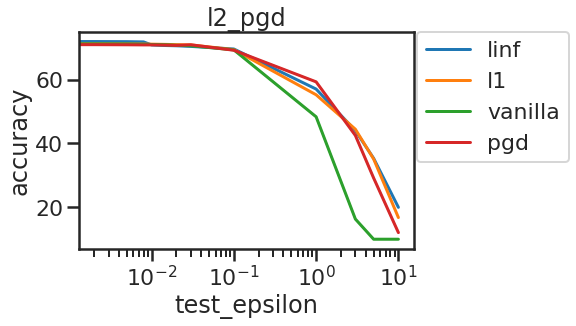

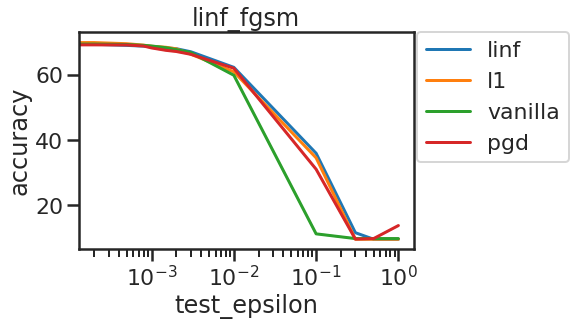

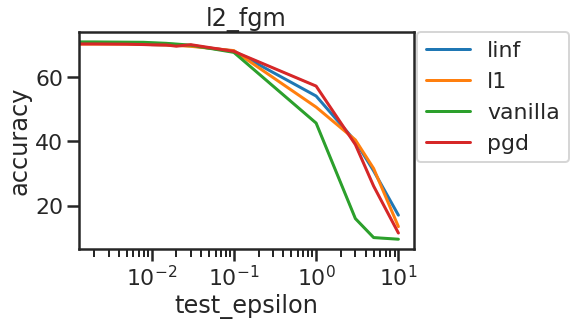

In [21]:
for attack in name_attacks:
    plt.figure()
    sns.lineplot(x="test_epsilon", y="accuracy",
                 hue="robust_training",   palette="tab10", 
                 data=df_results[(df_results.attack==attack)]).set_title(attack)
    plt.xscale('log')
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)


In [12]:
list_entries = []

# Hash table of parameters
parameters = {"epsilon": {}, "backbone": {}, "initial_learning_rate": {}, 
              "robust_training": {}, "epsilon_pgd_training":{}}

to_exclude = []
experiment_list_tmp = [element for i, element in enumerate(experiment_list) if i not in to_exclude]
for exp in experiment_list_tmp:

    for kk in parameters.keys():
        if exp[kk] in parameters[kk]:
            parameters[kk][exp[kk]].append(int(exp["model_name"]))
        else:
            parameters[kk][exp[kk]] = [int(exp["model_name"])]

# For all methods, do cross-val and create an entry of the results
backbones = ['OneLayer', 'OneLayer+pgd']
robust_trainings = [True,False]

for backbone in backbones:
    for robust_training in robust_trainings:
        
        if backbone == 'OneLayer+pgd':
            eps = parameters['epsilon_pgd_training'].keys()
        else:
            eps = parameters['epsilon'].keys()
            
        for ep in eps: #for each epsilon in training:
            
            if (backbone == 'Madry' and robust_training == True) or \
                (backbone == 'CNN+clipping' and robust_training == False):
                continue

            ids = list(set(parameters["backbone"][backbone]) & set(parameters["robust_training"][robust_training]))

            if backbone == 'OneLayer+pgd':
                ids = list(set(ids) & set(parameters["epsilon_pgd_training"][ep]) )
            else:
                ids = list(set(ids) & set(parameters["epsilon"][ep]) )
            
            if ids == []:
                continue

            # Cross-validation among learning rates and epsilons:
            best_acc = -1.0
            best_id = ids[0]
            for id in ids:
                file_name = results_dir + experiment_list[id]['model_name'] + '/results/acc_' + 'val' + '_' + name_attacks[0] + '.pkl'
                if not os.path.isfile(file_name):
                    print("Missing!! " + file_name)
                    continue
                with open(file_name, 'rb') as f:
                    tmp = pickle.load(f)

                acc = tmp[0.0]
                if acc>best_acc:
                    best_id = id
                    best_acc = acc

            entry = {"learning_rate": experiment_list[best_id]['initial_learning_rate'],
                    "backbone": experiment_list[best_id]['backbone'],
                    "robust_training": experiment_list[best_id]['robust_training'],
                    "epsilon": experiment_list[best_id]['epsilon'],
                    "epsilon_pgd_training": experiment_list[best_id]['epsilon_pgd_training']}

            dataset = "test"
            entry["attack"] = name_attacks[0]
            entry["experiment_id"] = best_id

            with open(results_dir + experiment_list[best_id]['model_name'] + '/results/acc_' + dataset + '_' + 
                name_attacks[0] + '.pkl', 'rb') as f:
                tmp = pickle.load(f)


            entry["train_epsilon"] = ep
            entry["accuracy"] =  100*tmp[0.0]
            list_entries.append(entry.copy())

df_results = pd.DataFrame.from_dict(list_entries) 

Missing!! /vast/robustness/onelayer/134/results/acc_val_linf_pgd.pkl


In [13]:
df_results

,learning_rate,backbone,robust_training,epsilon,epsilon_pgd_training,attack,experiment_id,train_epsilon,accuracy
0,0.00010,OneLayer,True,0.10000,0.10000,linf_pgd,125,0.10000,47.265625
1,0.00010,OneLayer,True,0.00010,0.10000,linf_pgd,56,0.00010,46.718750
2,0.00010,OneLayer,True,0.00001,0.10000,linf_pgd,24,0.00001,46.757812
3,0.00010,OneLayer,True,0.00100,0.10000,linf_pgd,58,0.00100,46.757812
4,0.00010,OneLayer,True,0.01000,0.10000,linf_pgd,26,0.01000,47.617188
5,0.00010,OneLayer,True,1.00000,0.10000,linf_pgd,126,1.00000,47.031250
6,0.00100,OneLayer,True,10.00000,0.10000,linf_pgd,120,10.00000,48.906250
7,0.00010,OneLayer,False,0.10000,0.10000,linf_pgd,3,0.10000,46.640625
8,0.00100,OneLayer+pgd,False,10.00000,0.10000,linf_pgd,86,0.10000,44.960938
9,0.00010,OneLayer+pgd,False,10.00000,0.00010,linf_pgd,88,0.00010,46.796875


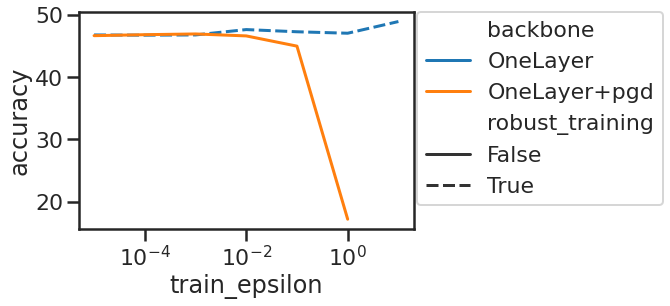

In [14]:
plt.figure()
sns.lineplot(x="train_epsilon", y="accuracy",
             hue="backbone",  style='robust_training', palette="tab10",
             data=df_results[(df_results.attack==name_attacks[0])])
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

[34, 10, 16, 22, 28]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


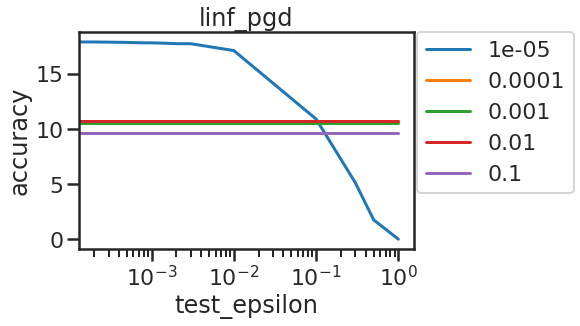

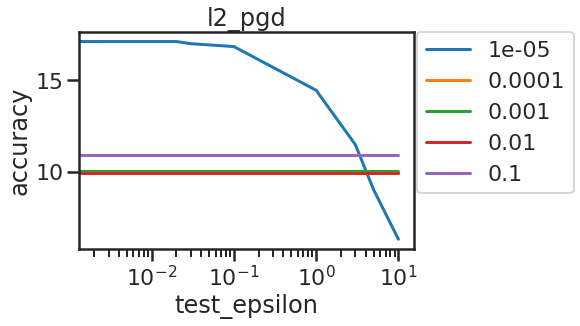

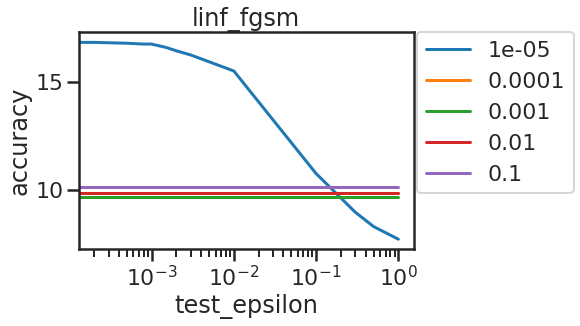

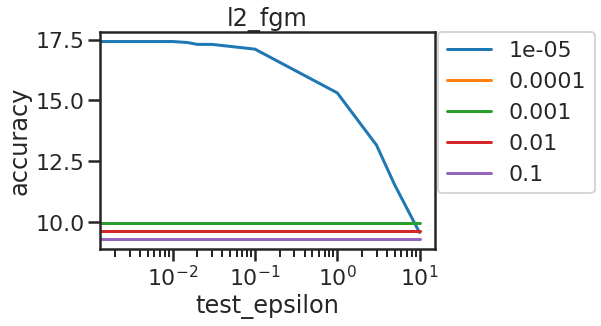

In [69]:
# Display learning rate impact
epsilon = 1e-0
backbone = 'CNN'
robust_training = True
epsilon_pgd_training = 1e-1
type_robust_training = 'linf'

# Hash table of parameters
parameters = {"epsilon": {}, "backbone": {}, "initial_learning_rate": {}, 
              "robust_training": {}, "l1_robustness": {}, "certificate": {}, "epsilon_pgd_training":{}}

to_exclude = []
experiment_list_tmp = [element for i, element in enumerate(experiment_list) if i not in to_exclude]
for exp in experiment_list_tmp:
    if not exp['data_set'] == 67: 
        continue

    for kk in parameters.keys():
        if exp[kk] in parameters[kk]:
            parameters[kk][exp[kk]].append(int(exp["model_name"]))
        else:
            parameters[kk][exp[kk]] = [int(exp["model_name"])]
                    
if robust_training:
    if type_robust_training=='linf':
        ids = list(set(parameters["backbone"][backbone]) & 
                set(parameters["robust_training"][True])&
                set(parameters["l1_robustness"][False])&
                set(parameters["certificate"][False])&
                set(parameters["epsilon"][epsilon]))
    elif type_robust_training=='l1':
        ids = list(set(parameters["backbone"][backbone]) & 
                set(parameters["robust_training"][True])&
                set(parameters["l1_robustness"][True])&
                set(parameters["certificate"][False])&
                set(parameters["epsilon"][epsilon]))
    elif type_robust_training=='certificate':
        ids = list(set(parameters["backbone"][backbone]) & 
                set(parameters["robust_training"][True])&
                set(parameters["l1_robustness"][True])&
                set(parameters["certificate"][True])&
                set(parameters["epsilon"][epsilon]))
else:
    ids = list(set(parameters["backbone"][backbone]) &
            set(parameters["robust_training"][robust_training]) & 
            set(parameters["epsilon_pgd_training"][epsilon_pgd_training]))

print(ids)
list_entries = []
for id in ids:
    entry = {"learning_rate": experiment_list[id]['initial_learning_rate'],
            "backbone": experiment_list[id]['backbone'],
            "robust_training": experiment_list[id]['robust_training'],
            "epsilon": experiment_list[id]['epsilon']}
 
    for dataset in ["val", "test"]:
        for attack in name_attacks:
            entry["dataset"] = dataset
            entry["attack"] = attack
            with open(results_dir + experiment_list[id]['model_name'] + '/results/acc_' + dataset + '_' + 
                attack + '.pkl', 'rb') as f:
                tmp = pickle.load(f)
            
            for test_epsilon in tmp.keys():
                entry["test_epsilon"] = test_epsilon
                entry["accuracy"] =  100*tmp[test_epsilon]
                list_entries.append(entry.copy())
                
df = pd.DataFrame.from_dict(list_entries) 
for attack in name_attacks:
    plt.figure()
    sns.lineplot(x="test_epsilon", y="accuracy",
                 hue="learning_rate",  palette="tab10",
                 data=df[df.dataset=='test'][df.attack==attack]).set_title(attack)
    plt.xscale('log')
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)


In [30]:
# Display epsilon
backbones = ['MLP+pgd']
robust_training = False
epsilon_pgd_training = 1e-3

list_entries = []
for backbone in backbones:
    for epsilon in list(parameters["epsilon"].keys()):

            
        if robust_training:
            ids = list(set(parameters["backbone"][backbone]) & set(parameters["epsilon"][epsilon]) &
                       set(parameters["robust_training"][robust_training])
                      & set(parameters["epsilon_pgd_training"][epsilon_pgd_training]))
        else:
            ids = list(set(parameters["backbone"][backbone]) &
                    set(parameters["robust_training"][robust_training])
                      & set(parameters["epsilon_pgd_training"][epsilon_pgd_training]))
            
        if len(ids)==0:
            continue
            
        # Cross-validation among learning rates:
        best_acc = 0.0
        best_id = -1
        for id in ids:
            acc = 0.0
            for attack in name_attacks:
                with open(results_dir + experiment_list[id]['model_name'] + '/results/acc_' + 'val' + '_' + 
                    attack + '.pkl', 'rb') as f:
                    tmp = pickle.load(f)
                
                ave_acc = 0.0
                for test_epsilon in list(tmp.keys())[:2]:
                    ave_acc += tmp[test_epsilon]
                ave_acc = ave_acc / len(tmp.keys())
                acc += ave_acc
            acc = acc / 2
            if acc>best_acc:
                best_id = id
                best_acc = acc
                
        print(best_id)
        entry = {"learning_rate": experiment_list[best_id]['initial_learning_rate'],
                "backbone": experiment_list[best_id]['backbone'],
                "robust_training": experiment_list[best_id]['robust_training'],
                "epsilon": experiment_list[best_id]['epsilon']}

        dataset = "test"
        for attack in name_attacks:
            entry["dataset"] = dataset
            entry["attack"] = attack
            with open(results_dir + experiment_list[best_id]['model_name'] + '/results/acc_' + dataset + '_' + 
                attack + '.pkl', 'rb') as f:
                tmp = pickle.load(f)

            for test_epsilon in tmp.keys():
                entry["test_epsilon"] = test_epsilon
                entry["accuracy"] =  100*tmp[test_epsilon]
                list_entries.append(entry.copy())
                
df = pd.DataFrame.from_dict(list_entries) 

for attack in name_attacks:
    plt.figure()
    sns.lineplot(x="test_epsilon", y="accuracy",
                 hue="epsilon",  style='backbone', palette="tab10",
                 data=df[df.attack==attack]).set_title(attack)
    plt.xscale('log')
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)


KeyError: 'MLP+pgd'

[1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399]
1376
[1365, 1366, 1367, 1368, 1369]
1366
[1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407]
1408


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


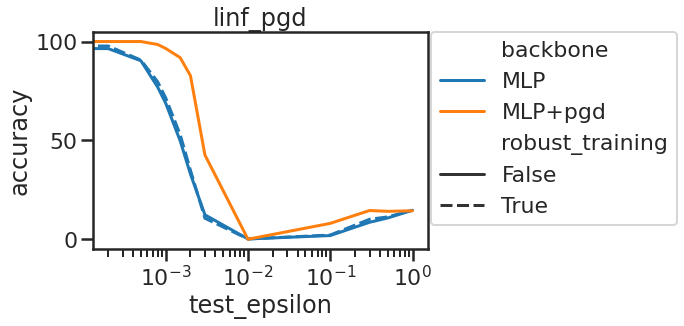

<Figure size 432x288 with 0 Axes>

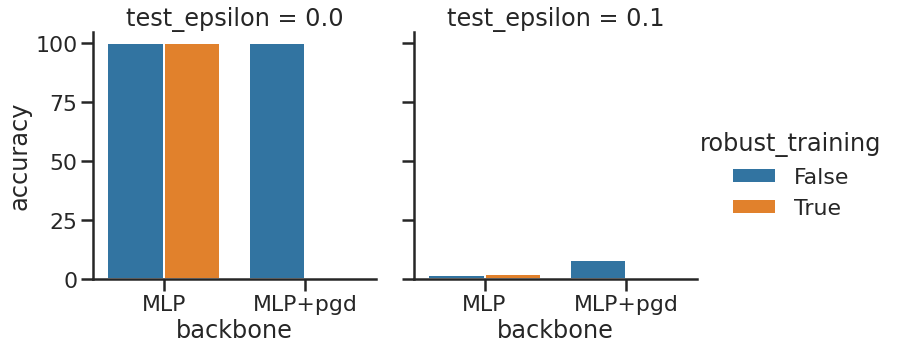

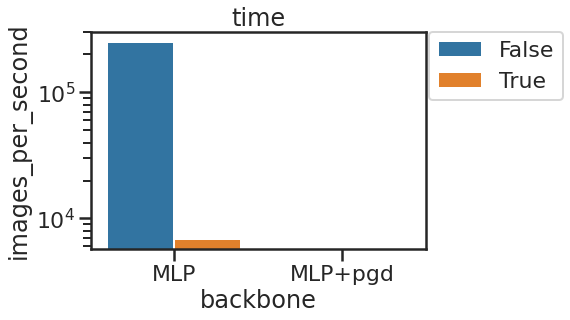

In [60]:
# Display best
backbones = ['MLP', 'MLP+pgd']
robust_trainings = [True,False]

list_entries = []
for backbone in backbones:
    for robust_training in robust_trainings:
        if (backbone == 'Madry' and robust_training == True) or \
            (backbone == 'CNN+clipping' and robust_training == False):
            continue
            
        ids = list(set(parameters["backbone"][backbone]) & set(parameters["robust_training"][robust_training]))
        
        if backbone == 'MLP+pgd' and robust_training == True:
            continue
            
        if ids == []:
            continue
        print(ids)
        
        # Cross-validation among learning rates:
        best_acc = 0.0
        best_id = -1
        for id in ids:
            #if (experiment_list[id]['backbone'] == 'CNN+pgd') and experiment_list[id]["epsilon_pgd_training"] == 0.3:
            #    continue 
            acc = 0.0
            for attack in [name_attacks[0]]:
                with open(results_dir + experiment_list[id]['model_name'] + '/results/acc_' + 'val' + '_' + 
                    attack + '.pkl', 'rb') as f:
                    tmp = pickle.load(f)
                
                ave_acc = 0.0
                for test_epsilon in list(tmp.keys())[0:1]:
                    ave_acc += tmp[test_epsilon]
                ave_acc = ave_acc / len(tmp.keys())
                acc += ave_acc
            acc = acc / 2
            if acc>best_acc:
                best_id = id
                best_acc = acc

        entry = {"learning_rate": experiment_list[best_id]['initial_learning_rate'],
                "backbone": experiment_list[best_id]['backbone'],
                "robust_training": experiment_list[best_id]['robust_training'],
                "epsilon": experiment_list[best_id]['epsilon']}

        dataset = "test"
        print(best_id)
        for attack in name_attacks:
            entry["dataset"] = dataset
            entry["attack"] = attack
            
            if not backbone == 'Madry':
                with open(results_dir + experiment_list[best_id]['model_name'] + 
                          '/results/training_time.pkl', 'rb') as f:
                    tmp = pickle.load(f)
                entry["images_per_second"] = np.mean(tmp) 
                entry["std_images_per_second"] = np.std(tmp) 
                
            with open(results_dir + experiment_list[best_id]['model_name'] + '/results/acc_' + dataset + '_' + 
                attack + '.pkl', 'rb') as f:
                tmp = pickle.load(f)

            for test_epsilon in tmp.keys():
                entry["test_epsilon"] = test_epsilon
                entry["accuracy"] =  100*tmp[test_epsilon]
                list_entries.append(entry.copy())
                  
df = pd.DataFrame.from_dict(list_entries) 

for attack in [name_attacks[0]]:
    plt.figure()
    sns.lineplot(x="test_epsilon", y="accuracy",
                 hue="backbone",  style='robust_training', palette="tab10",
                 data=df[df.attack==attack]).set_title(attack)
    plt.xscale('log')
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

    plt.figure()
    epsilon = 0.1
    if attack == "l2_pgd" or attack == "l2_fgm" :
        epsilon = 1
    sns.catplot(x="backbone", y="accuracy",
                 hue="robust_training", col="test_epsilon", palette="tab10",kind="bar",
                 data=df[(df.test_epsilon == 0)| (df.test_epsilon == epsilon)][df.attack==attack])
    #plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

plt.figure()
sns.barplot(x="backbone", y="images_per_second",
             hue="robust_training", palette="tab10",
             data=df).set_title("time")
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

In [ ]:
df[(df.test_epsilon==0.01)&(df.attack=='linf_pgd')]

In [87]:
df[df.backbone=="Madry"][df.attack=="linf_pgd"][df.test_epsilon == 0.3 ]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,learning_rate,backbone,robust_training,epsilon,dataset,attack,test_epsilon,accuracy,images_per_second,std_images_per_second
218,0.001,Madry,True,0.1,test,linf_pgd,0.3,93.515625,NaN,NaN
270,0.001,Madry,True,0.1,test,linf_pgd,0.3,93.515625,NaN,NaN


In [107]:
df[df.backbone=="Madry"][df.attack=="linf_fgsm"][df.test_epsilon == 0.3 ]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,learning_rate,backbone,robust_training,epsilon,dataset,attack,test_epsilon,accuracy,images_per_second,std_images_per_second
244,0.001,Madry,True,0.1,test,linf_fgsm,0.3,95.507812,NaN,NaN
296,0.001,Madry,True,0.1,test,linf_fgsm,0.3,95.507812,NaN,NaN
